In [1]:
# Mass estimate of Kepler-10c using RadVel package (https://github.com/California-Planet-Search/radvel.git)

%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.likelihood
from radvel.plot import orbit_plots, mcmc_plots

matplotlib.rcParams['font.size'] = 14

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
In accordance with NEP 32, the function fv was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
In accordance with NEP 32, the function ipmt was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
In accordance with NEP 32, the function irr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
In accordance with NEP 32, the function mirr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_finan

In [2]:
# Loading data for Kepler 10-c from Weiss et.al 2016
data = np.genfromtxt('apj522668t1_ascii.txt', delimiter = '\t', dtype = 'str', skip_header=6, skip_footer = 1) 

Weiss reported her radial velocity uncertainty with jitter added in. It is certainly possible to obtain the intrinsic RV uncertainty by subtracting the reported telescope-specific jitter value (table 3 in Weiss 2016) in quadrature from the reported total error using the following equation (Equation 1 in Weiss 2016):

$$
\mathcal{L}=\prod_{i} \frac{1}{\sqrt{2 \pi\left(\sigma_{i}^{2}+\sigma_{j}^{2}\right)}} \exp \left[-\frac{\left(\mathrm{RV}_{i}-\mathrm{RV}_{mod, i}\right)^{2}}{2\left(\sigma_{i}^{2}+\sigma_{j}^{2}\right)}\right]
$$

In [3]:
t = data[:,0]
t = np.array([float(i) for i in t])
t 

array([ 173.900499,  174.877797,  175.773348,  176.862854,  177.923401,
        178.922398,  179.972876,  180.896063,  181.969271,  182.847887,
        183.760854,  183.945387,  184.877994,  206.889914,  208.885123,
        208.890922,  211.830107,  269.71177 ,  269.720925,  269.733899,
        270.715114,  270.733655,  272.756489,  273.714025,  273.720425,
        273.727555,  412.04715 ,  413.004124,  414.004814,  415.111272,
        417.998478,  418.121283,  419.027179,  420.062974,  421.006521,
        421.969467,  443.050045,  444.031958,  444.964655,  444.977237,
        445.068315,  450.972744,  451.987745,  473.81361 ,  476.86488 ,
        479.902118,  503.897962,  505.056086,  507.012774,  511.985723,
        512.805268,  514.80255 , 1172.682384, 1172.704768, 1187.57572 ,
       1187.596901, 1203.106739, 1203.661644, 1203.689793, 1215.691945,
       1215.713149, 1216.704755, 1216.719003, 1225.568254, 1225.589446,
       1226.447899, 1226.664948, 1227.422428, 1227.441641, 1228.

In [4]:
rv = data[:,1]
rv = np.array([float(i) for i in rv])
rv

array([  5.21,   0.37,   3.31,   1.1 ,  -6.28,   5.96,   0.9 ,   2.56,
        -9.41,  -8.01,  -1.3 ,  -3.17,  -1.17,   0.64,  -8.82,  -6.76,
        10.61,  -0.59,  -0.77,   5.59,  -0.47,  -6.97,   3.48,   1.35,
         4.13,  -0.49,  -3.91,  -2.11,  -9.03,  -0.13,   2.79,  -2.3 ,
        -0.98,   2.83,   2.53,   1.75,  -1.13,  -1.08,  -3.66,  -8.96,
        -3.82,  -0.41,  -0.93,   3.54,  -1.89,  -0.74,   2.84,  -4.34,
        -1.3 ,  -4.08,  -4.57,  -4.5 ,  -2.7 ,  -3.04,  -1.67,   4.37,
        -5.79,  -0.55,  -4.47,  -3.45,  -7.55,   2.06,  -2.56,  -7.06,
        -8.06,  -2.83,  -0.54, -13.21,   0.41,   2.16,  -2.77,  -1.7 ,
         7.45,  10.45,   3.48,  -0.48,   1.01,   0.59,   2.11,  -5.91,
         4.45,  -1.01,  -3.28,  -4.78,  -5.06,  -8.23,  -6.97,  -9.35,
         1.87,   3.11,   3.74,  -4.07,  -4.84,   0.67,   4.18,   3.13,
        -5.11,   5.83,   3.53,   4.21,   5.13,   2.94,  -0.84, -16.52,
         3.71,   1.78,  -1.19,   0.  ,   4.16,  -8.77,  -0.79,   0.46,
      

In [5]:
rv_error = data[:,2]
rv_error = np.array([float(i) for i in rv_error])
rv_error

array([ 4.18,  3.94,  3.95,  3.96,  3.97,  3.96,  4.  ,  3.94,  3.96,
        3.97,  3.92,  3.99,  3.93,  4.04,  4.28,  5.28,  4.38,  4.22,
        4.08,  4.04,  3.99,  3.98,  4.03,  3.97,  5.03,  4.  ,  3.94,
        3.94,  3.95,  4.12,  3.96,  3.93,  4.06,  3.95,  3.93,  3.97,
        3.9 ,  3.93,  4.34,  3.93,  4.  ,  3.92,  3.95,  3.97,  3.88,
        3.98,  3.89,  4.06,  3.92,  3.86,  3.86,  3.93,  3.05,  3.11,
        3.32,  3.18,  3.9 ,  3.45,  3.32,  3.04,  3.22,  4.47,  4.77,
        3.76,  3.31,  2.94,  4.53,  9.66,  2.91,  2.95,  2.94,  3.14,
        3.22,  3.06,  3.05,  3.33,  2.84,  3.36,  2.98,  4.83,  2.97,
        4.25,  3.98,  3.42,  3.65,  3.33,  3.28,  3.47,  3.27,  3.27,
        3.45,  3.36,  3.48,  3.91,  2.84,  2.97,  3.09,  3.03,  2.91,
        3.02,  2.84,  2.97,  2.81,  9.34,  2.98,  2.86,  2.98,  3.23,
        3.08,  2.93,  2.98,  3.32,  3.25,  3.18,  3.06,  2.94,  2.94,
        2.88,  3.  ,  2.86,  2.84,  3.41,  3.09, 11.61,  5.82,  7.95,
        3.27,  3.19,

In [6]:
inst = data[:,4]
inst = np.array(inst)
inst

array(['HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HIRES', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'H

In [7]:
x = radvel.utils.bintels(t,rv,rv_error,inst,binsize = 0.000001) #bins by telescope. can also use list comp. 
hires_t = x[0][:72]
hires_rv = x[1][:72]
hires_rv_error = x[2][:72]
hires_rv_error = np.sqrt(hires_rv_error**2 - 3.62**2) #removing jitter
hires_inst = x[3][:72]

harps_one_t = x[0][72:127]
harps_one_rv = x[1][72:127]
harps_one_rv_error = x[2][72:127]
harps_one_rv_error = np.sqrt(harps_one_rv_error**2 - 2.49**2)
harps_one_inst = x[3][72:127]

harps_two_t = x[0][127:]
harps_two_rv = x[1][127:]
harps_two_rv_error = x[2][127:]
harps_two_rv_error = np.sqrt(harps_two_rv_error**2 - 2.49**2)
harps_two_inst = x[3][127:]

gamma_hires = np.median(x[1][:72]) # median of binned radial velocity data for HIRES observation
gamma_harps_one = np.median(x[1][72:127])
gamma_harps_two = np.median(x[1][127:])



In [8]:
hires = [hires_t,hires_rv,hires_rv_error,hires_inst] #hires data
harps_one = [harps_one_t,harps_one_rv,harps_one_rv_error,harps_one_inst]
harps_two = [harps_two_t,harps_two_rv,harps_two_rv_error,harps_two_inst]
starname = 'Kepler 10'
instnames = ['HIRES', 'HARPS1', 'HARPS2']
nplanets = 2    # number of planets in the system
planet_letters = {1: 'b', 2: 'c'}   # map the numbers in the Parameters keys to planet letters (for plotting and tables)

In [10]:
def initialize_model():
    time_base = 0 #BJD: barycentric julian date: center of mass from solar system (barycentric correction b/c different sides of solar system from earth)
    params = radvel.Parameters(nplanets,basis='per tc secosw sesinw logk')
    params['per1'] = radvel.Parameter(value=0.837491331) # period [days]
    params['tc1'] = radvel.Parameter(value=2454964.57475-2454900) # time of transit
    params['secosw1'] = radvel.Parameter(value=0) #sqrt(e)*cos(omega)
    params['sesinw1'] = radvel.Parameter(value=0) #sqrt(e)*sin(omega)
    params['logk1'] = radvel.Parameter(value=0.518514) # log(semi-amplitude)
    params['per2'] = radvel.Parameter(value=45.29431717)
    params['tc2'] = radvel.Parameter(value= 2454971.67748-2454900)
    params['secosw2'] = radvel.Parameter(value=0)
    params['sesinw2'] = radvel.Parameter(value=0)
    params['logk2'] = radvel.Parameter(value=0.149219113)
    mod = radvel.model.RVModel(params)
    mod.params['dvdt'] = radvel.Parameter(value=0) # short term linear shift for binary system
    mod.params['curv'] = radvel.Parameter(value=0) # long term quadratic shift for binary system
    return mod

# By reparameterizing eccentricity/argument of periastron in this way, we create a circle where the distance from the 
# center of the circle corresponds to the eccentricity (i.e points on the edge correspond to e=1, points in the middle 
# correspond to e=0). This helps mitigate against an artificial build up of eccentricities near zero (it would otherwise be 
# difficult to tell if e=0 build up is due to a boundary condition at e=0 or not).

# Exploring semi-amplitude in log-space -> explore lower values more often 

# Transit time selection is a bit more nuanced than it initially appears. If data for transit time occurs well-
# before or well-after rv data then we have to worry about aliasing (see stale ephemerides). 
# Not a problem for Kepler-10 data


In [11]:
def initialize_likelihood(t,rv,rv_error,suffix):
    like = radvel.likelihood.RVLikelihood(
        mod, t, rv, rv_error, suffix=suffix)
    return like
mod = initialize_model()

# Build up HIRES likelihood
like_hires = initialize_likelihood(hires_t,hires_rv,hires_rv_error,'_hires')
like_hires.params['gamma_hires'] = radvel.Parameter(gamma_hires)
like_hires.params['jit_hires'] = radvel.Parameter(value=3.62)# Weiss (2016)

# Build up HARPS-1 likelihood
like_harps_one = initialize_likelihood(harps_one_t,harps_one_rv,harps_one_rv_error,'_harps_one')
like_harps_one.params['gamma_harps_one'] = radvel.Parameter(gamma_harps_one)
like_harps_one.params['jit_harps_one'] = radvel.Parameter(value=2.49) # Weiss (2016)

# Build up HARPS-2 likelihood
like_harps_two = initialize_likelihood(harps_two_t,harps_two_rv,harps_two_rv_error,'_harps_two')
like_harps_two.params['gamma_harps_two'] = radvel.Parameter(gamma_harps_one)
like_harps_two.params['jit_harps_two'] = radvel.Parameter(value=2.49) # Weiss (2016)

# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood([like_hires,like_harps_one,like_harps_two])
like.params['secosw1'].vary = True
like.params['sesinw1'].vary = True
like.params['secosw2'].vary = True
like.params['sesinw2'].vary = True
like.params['per1'].vary = True
like.params['per2'].vary = True
like.params['tc1'].vary = True
like.params['tc2'].vary = True
like.params['dvdt'].vary= False
like.params['curv'].vary= False
print(like)

parameter                     value      vary
per1                       0.837491       True
tc1                         64.5748       True
secosw1                           0       True
sesinw1                           0       True
logk1                      0.518514       True
per2                        45.2943       True
tc2                         71.6775       True
secosw2                           0       True
sesinw2                           0       True
logk2                      0.149219       True
dvdt                              0      False
curv                              0      False
gamma_hires                  -0.375       True
jit_hires                      3.62       True
gamma_harps_one               -0.55       True
jit_harps_one                  2.49       True
gamma_harps_two               -0.55       True
jit_harps_two                  2.49       True
tp1                         64.3654           
e1                                0           
w1            

In [12]:
import copy

# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
# Uniform priors for everything but period/transit time

# Period and Transit time from transit modelling in Morton et al. 2016. While, Gajdoš et al. 2019 provided slightly
# better constraints for period/transit time, period/transit time are very well constrained across all papers,
# so we place an outsized importance on the estimate of planet radius which will be used to calculate planet density. 
# An estimate for planet radius was not reported in Gajdoš 2019. 

post.priors += [radvel.prior.EccentricityPrior(nplanets)] # Keeps eccentricity < 1
post.priors += [radvel.prior.HardBounds( 'logk2', -1, 4)]
post.priors += [radvel.prior.HardBounds( 'logk1', -1, 4)]
post.priors += [radvel.prior.Gaussian('per2',45.29431717, 0.00005283)]
post.priors += [radvel.prior.Gaussian('tc2',2454971.67748-2454900,0.00089)]
post.priors += [radvel.prior.Gaussian('per1',0.837491331,0.000000272)]
post.priors += [radvel.prior.Gaussian('tc1',2454964.57475-2454900,0.000261)]
post.priors += [radvel.prior.HardBounds( 'gamma_hires', gamma_hires - 3*np.std(x[1][:72]), gamma_hires + 3*np.std(x[1][:72]))]
post.priors += [radvel.prior.HardBounds( 'gamma_harps_one', gamma_harps_one - 3*np.std(x[1][72:127]),gamma_harps_one+ 3*np.std(x[1][72:127]))]
post.priors += [radvel.prior.HardBounds( 'gamma_harps_two', gamma_harps_two - 3*np.std(x[1][127:]),gamma_harps_two + 3*np.std(x[1][127:]))]
post.priors += [radvel.prior.HardBounds( 'jit_hires', 0, 10)] 
post.priors += [radvel.prior.HardBounds( 'jit_harps_one', 0, 10)] 
post.priors += [radvel.prior.HardBounds( 'jit_harps_two', 0, 10)] 

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(),
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )

print("Initial loglikelihood = %f" % post0.logprob())
print("Final loglikelihood = %f" % post.logprob())
print(post)

Initial loglikelihood = -599.792532
Final loglikelihood = -563.365027
parameter                     value      vary
per1                       0.837491       True
tc1                         64.5748       True
secosw1                   -0.255831       True
sesinw1                -0.000181879       True
logk1                       1.00833       True
per2                        45.2943       True
tc2                         71.6775       True
secosw2                    0.145957       True
sesinw2                     0.42167       True
logk2                         1.085       True
dvdt                              0      False
curv                              0      False
gamma_hires            -0.000311472       True
jit_hires                   3.46165       True
gamma_harps_one            0.148093       True
jit_harps_one               2.32197       True
gamma_harps_two          -0.0169302       True
jit_harps_two               2.44213       True
tp1                         64.7668   

In [13]:
df = radvel.mcmc(post,nwalkers=45,nrun=15000, savename='rawchains.h5', minTz=False)
# G-R: Gelman Rubin Metric: how much variation within a given chain versus how much variation between all of the chains
# < 1.01


270000/5400000 (5.0%) steps complete; Running 1100.83 steps/s; Mean acceptance rate = 33.3%; Min Auto Factor =  37; Max Auto Relative-Change =   inf; Min Tz = 3431.6; Max G-R = 1.008
Discarding burn-in now that the chains are marginally well-mixed

774000/5400000 (14.3%) steps complete; Running 1020.15 steps/s; Mean acceptance rate = 31.1%; Min Auto Factor =  41; Max Auto Relative-Change = 0.0272; Min Tz = 6524.8; Max G-R = 1.004
Chains are well-mixed after 774000 steps! MCMC completed in 15.6 minutes




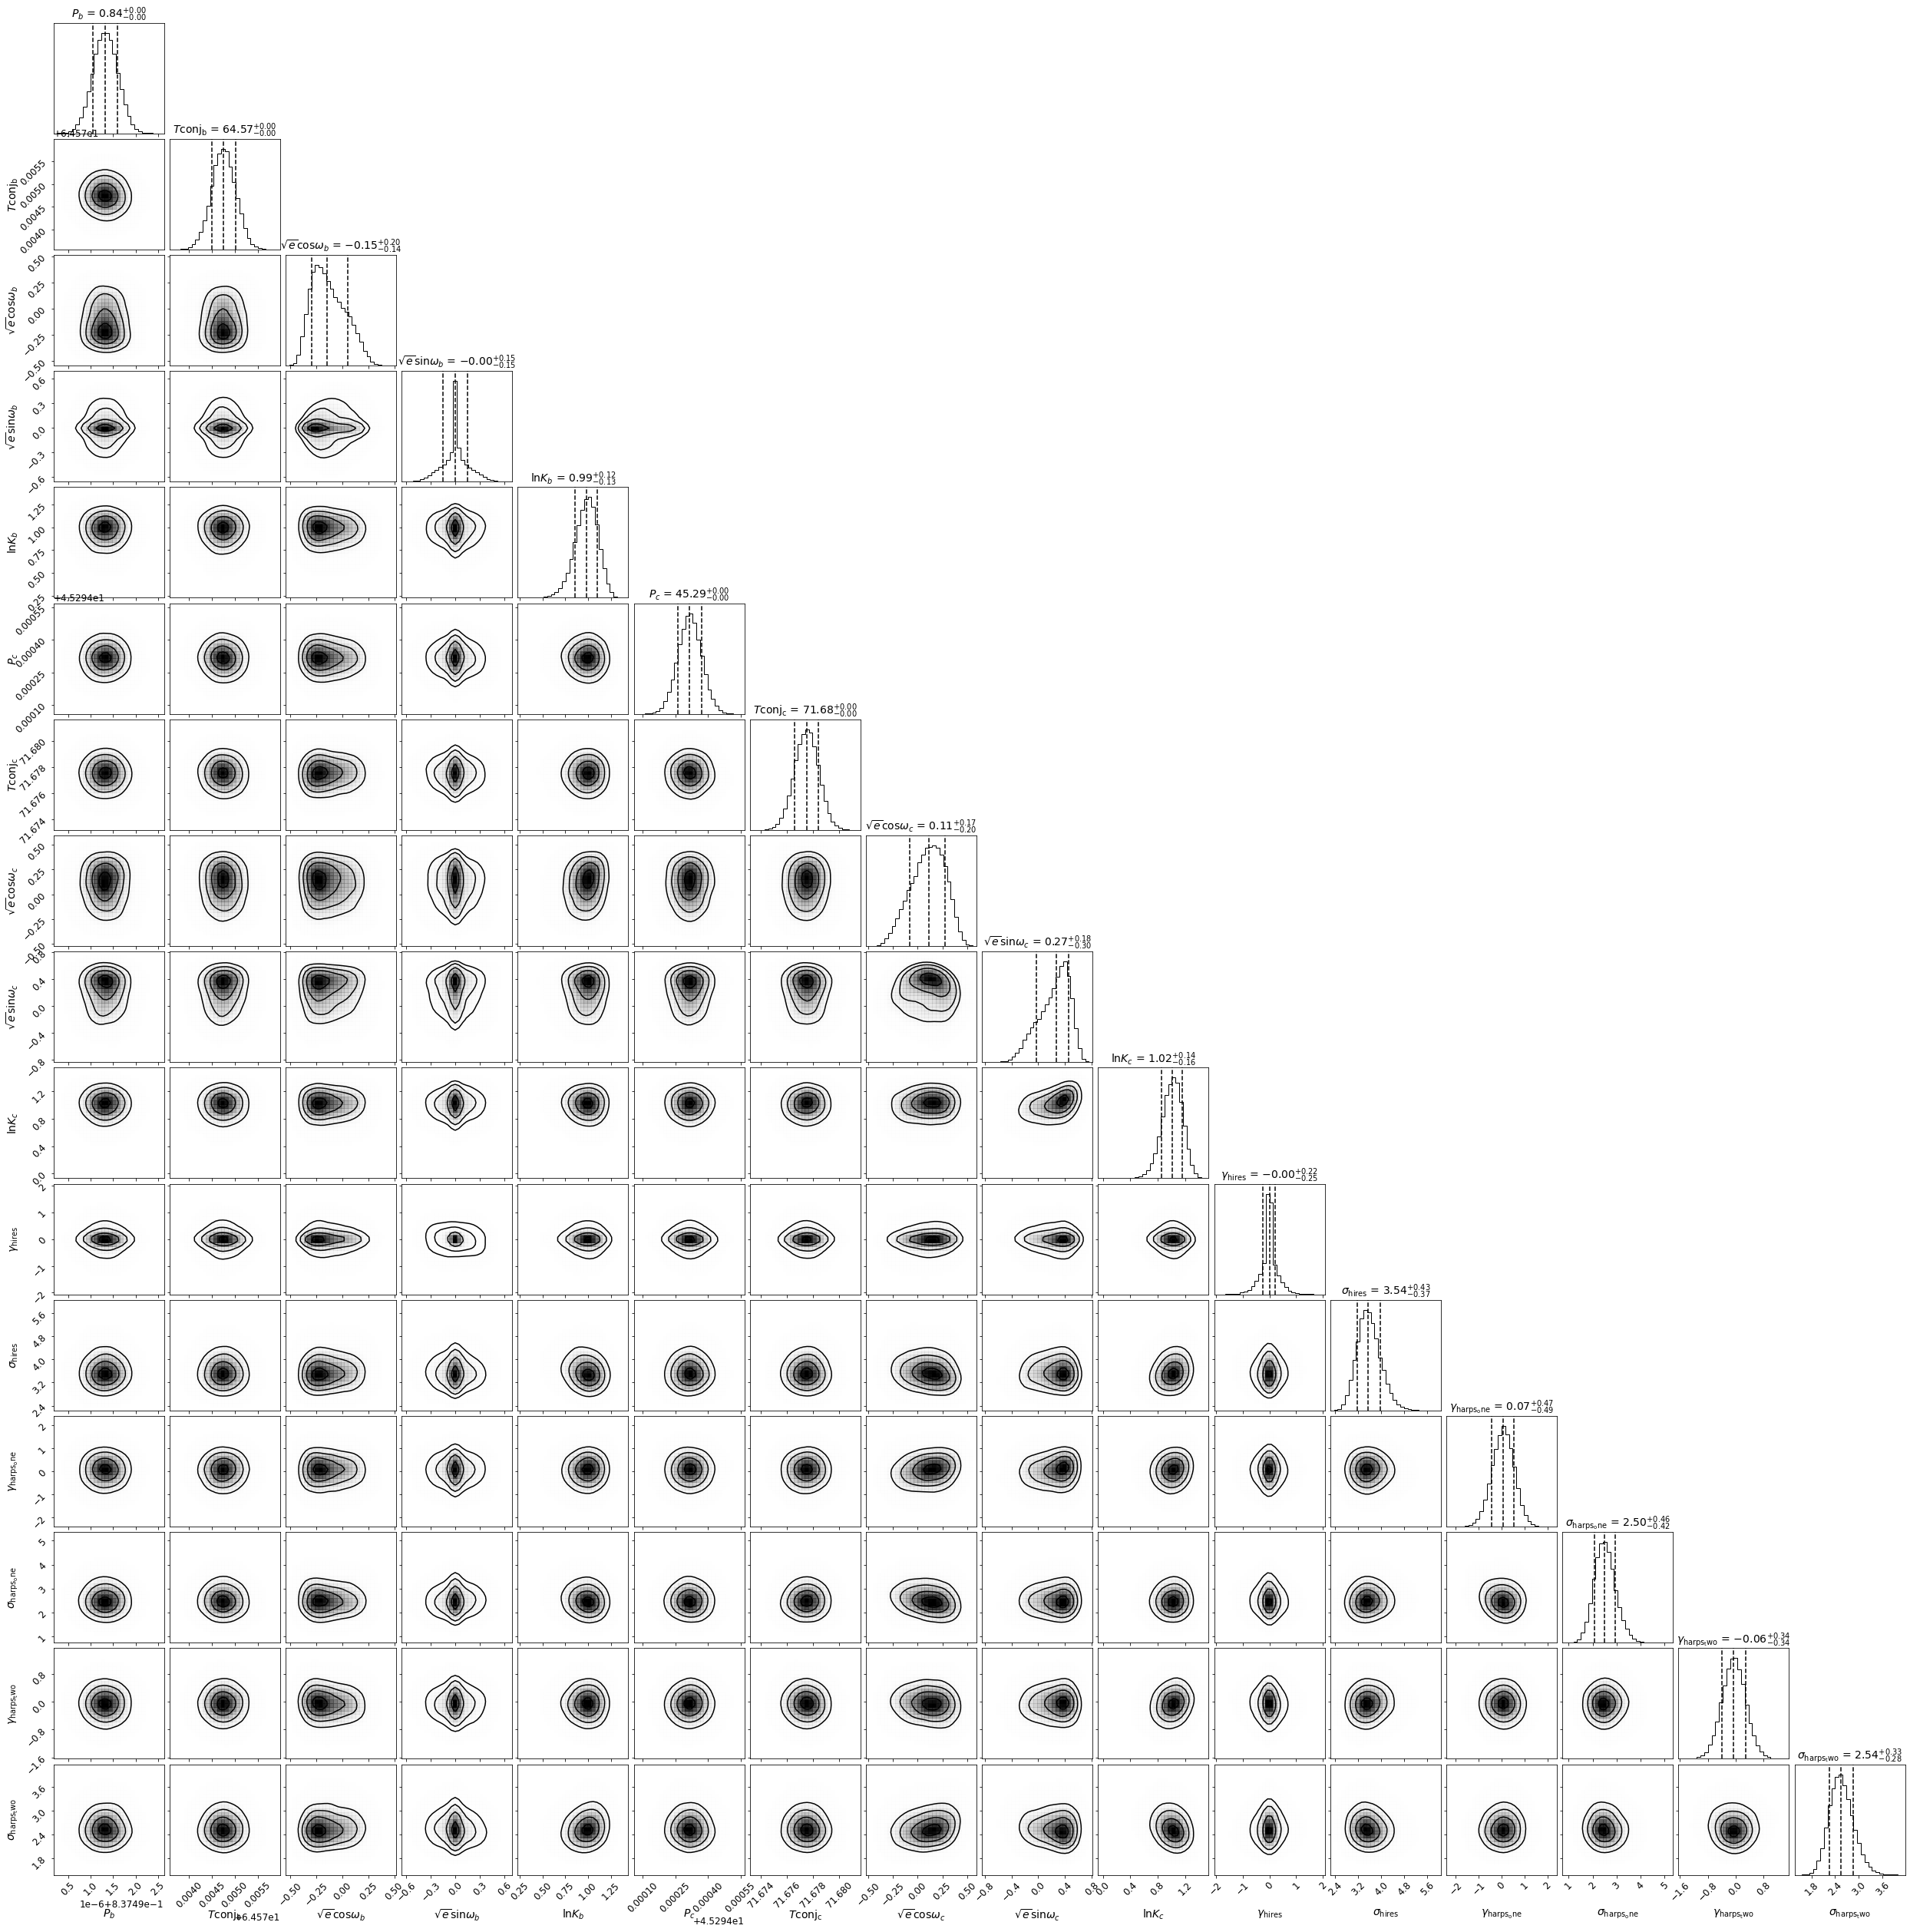

In [14]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()

(<Figure size 540x786.857 with 5 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7febbc3625b0>])

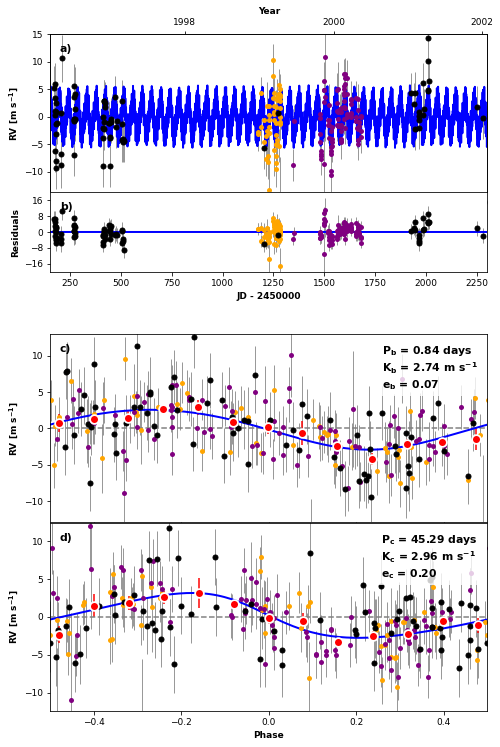

In [15]:
RVPlot = orbit_plots.MultipanelPlot(post, legend=False)
RVPlot.plot_multipanel()

In [16]:
df

,per1,tc1,secosw1,sesinw1,logk1,per2,tc2,secosw2,sesinw2,logk2,gamma_hires,jit_hires,gamma_harps_one,jit_harps_one,gamma_harps_two,jit_harps_two,lnprobability
0,0.837491,64.574834,0.081615,-0.001477,0.917125,45.294267,71.676389,0.176645,0.445942,1.229241,-0.000121,3.461342,1.221174,2.407431,-0.052934,2.185313,-570.255408
1,0.837491,64.574834,0.081615,-0.001477,0.917125,45.294267,71.676389,0.176645,0.445942,1.229241,-0.000121,3.461342,1.221174,2.407431,-0.052934,2.185313,-570.255408
2,0.837491,64.574834,0.081615,-0.001477,0.917125,45.294267,71.676389,0.176645,0.445942,1.229241,-0.000121,3.461342,1.221174,2.407431,-0.052934,2.185313,-570.255408
3,0.837491,64.574834,0.081615,-0.001477,0.917125,45.294267,71.676389,0.176645,0.445942,1.229241,-0.000121,3.461342,1.221174,2.407431,-0.052934,2.185313,-570.255408
4,0.837491,64.574834,0.081615,-0.001477,0.917125,45.294267,71.676389,0.176645,0.445942,1.229241,-0.000121,3.461342,1.221174,2.407431,-0.052934,2.185313,-570.255408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503995,0.837491,64.574854,0.250687,0.350681,0.937150,45.294273,71.676917,0.134492,0.456026,1.111849,0.057649,3.434796,0.273691,2.274626,0.318452,2.451028,-569.207601
503996,0.837491,64.574854,0.250687,0.350681,0.937150,45.294273,71.676917,0.134492,0.456026,1.111849,0.057649,3.434796,0.273691,2.274626,0.318452,2.451028,-569.207601
503997,0.837491,64.574854,0.250687,0.350681,0.937150,45.294273,71.676917,0.134492,0.456026,1.111849,0.057649,3.434796,0.273691,2.274626,0.318452,2.451028,-569.207601
503998,0.837491,64.574806,0.328795,0.348662,0.908149,45.294272,71.676796,0.203358,0.445993,1.128910,0.206553,3.363570,-0.010549,2.255871,0.477386,2.529324,-572.742827


In [17]:
k_c = np.array(df.logk2)
k_c = np.power(np.e,k_c)
per_c = np.array(df.per2)
ecc_c = np.array(df.secosw2)**2 + np.array(df.sesinw2)**2
ecc_b = np.array(df.secosw1)**2 + np.array(df.sesinw1)**2
stellar_mass_median = 0.92
stellar_mass_unc = 0.018
stellar_mass = np.random.randn(len(k_c))*stellar_mass_unc + stellar_mass_median

In [67]:
mass = radvel.utils.Msini(k_c, per_c, stellar_mass, ecc_c, Msini_units='earth')
print('Mass estimate of Kepler-10c:' , np.median(mass))
lo, med, hi = np.percentile(mass, [16, 50, 84])
uerr, lerr = hi - med, med - lo
print('Upper Error:', uerr, ', Lower Error:',lerr)

Mass estimate of Kepler-10c: 14.3716637413428
Upper Error: 2.093789975089166 , Lower Error: 2.0256967265263786


In [69]:
k_b = np.array(df.logk1)
k_b = np.power(np.e,k_b)
per_b = np.array(df.per1)
mass_b = radvel.utils.Msini(k_b, per_b, stellar_mass, ecc_b, Msini_units='earth')
print('Mass estimate of Kepler-10b:' , np.median(mass_b))
lo_b, med_b, hi_b = np.percentile(mass_b, [16, 50, 84])
uerr_b, lerr_b = hi_b - med_b, med_b - lo_b
print('Upper Error:', uerr_b, ', Lower Error:',lerr_b)

Mass estimate of Kepler-10b: 3.7228897629230415
Upper Error: 0.4633904930781929 , Lower Error: 0.4674902845343407


# Improving Priors for GP model

In addition to plotting RV versus time, we can also plot power vs frequency to get a better sense of where
the strongest periodic signals are located. These should correspond to the periods of planets 
or the stellar rotation period which will give us better priors for our $\eta_3$ hyperparameter in our GP model. 

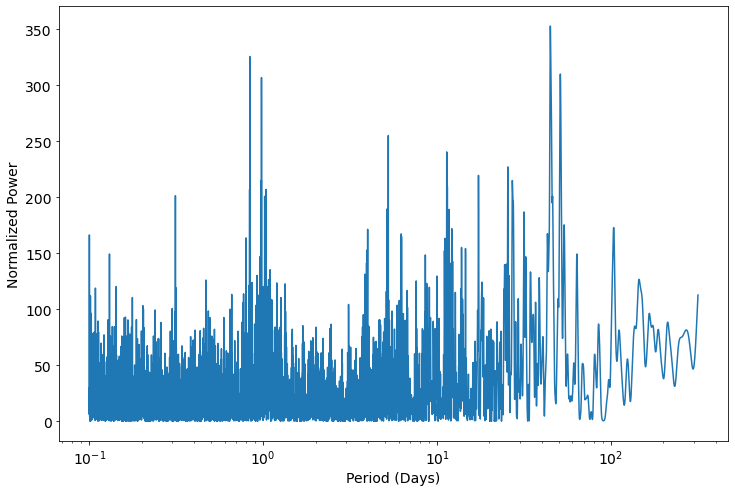

In [12]:
import scipy.signal as signal
import matplotlib.pyplot as plt
# freqs = np.logspace(-3,1,1000)
pers = np.logspace(-1,2.5,10000)
freqs = 2*np.pi/pers
pgram = signal.lombscargle(t, rv, freqs) # lomb scargle periodogram used b/c normal scipy periodogram requires equally spaced time series
fig , ax = plt.subplots(1,figsize=(12,8))
ax.plot(pers,pgram)
ax.set_xlabel('Period (Days)')
ax.set_ylabel('Normalized Power')
ax.set_xscale('log')
plt.show()

Now, we can subtract away the signal from planets B and C. Our residuals will only have signals from additional planets and the stellar rotation period

In [58]:
# If parameters are not well correlated, we can run into issues by just using np.median, so we instead use the maximum 
# likelihood for the best choice of parameters.
x = np.array(df[df.lnprobability == max(df.lnprobability)])[0]
df[df.lnprobability == max(df.lnprobability)]

,per1,tc1,secosw1,sesinw1,logk1,per2,tc2,secosw2,sesinw2,logk2,gamma_hires,jit_hires,gamma_harps_one,jit_harps_one,gamma_harps_two,jit_harps_two,lnprobability
405640,0.837491,64.574877,-0.224212,-0.008996,1.010661,45.294338,71.676792,0.212061,0.439899,1.049599,0.149059,3.337701,0.019288,2.29531,-0.099772,2.492341,-564.488056
405641,0.837491,64.574877,-0.224212,-0.008996,1.010661,45.294338,71.676792,0.212061,0.439899,1.049599,0.149059,3.337701,0.019288,2.29531,-0.099772,2.492341,-564.488056
405642,0.837491,64.574877,-0.224212,-0.008996,1.010661,45.294338,71.676792,0.212061,0.439899,1.049599,0.149059,3.337701,0.019288,2.29531,-0.099772,2.492341,-564.488056


(175.0, 200.0)

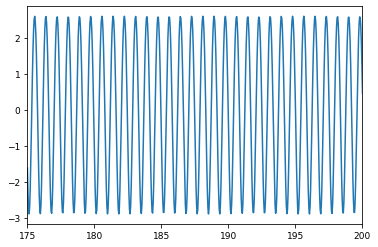

In [160]:
# RVs for planet B using parameters in maximum likelihood
from radvel.kepler import rv_drive
e_b = x[2]**2 + x[3]**2
om_b = np.arctan2(x[3],x[2])
orbel = [x[0], x[1], e_b, om_b, np.power(np.e,x[4])]
t_new = np.linspace(min(t),max(t),50000)
rv_b = rv_drive(t, orbel,use_c_kepler_solver=True)# use_c_kepler_solver: Kepler's equation gives eccentric anomaly, E, both outside/inside a sin function => 
# transcendental equation => cannot analytically solve => use_c_kepler_solver is a way to solve it.  
rv_b_new = rv_drive(t_new, orbel,use_c_kepler_solver=True)

plt.plot(t_new,rv_b_new)
plt.xlim((175,200))

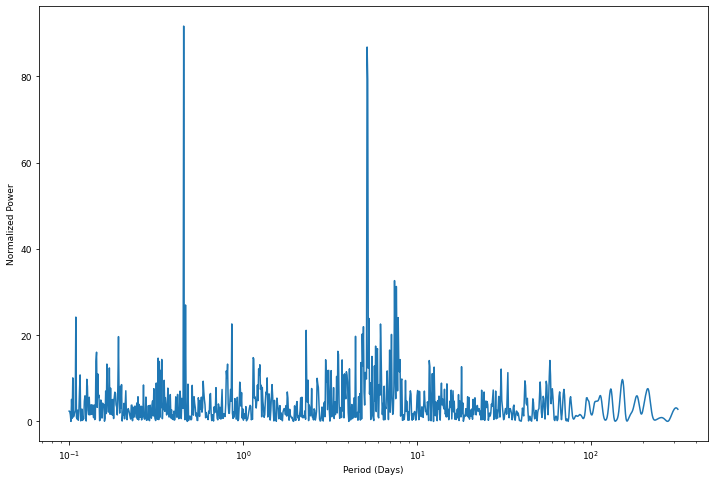

In [154]:
pgram_b = signal.lombscargle(t, rv_b, freqs) # lomb scargle periodogram used b/c normal scipy periodogram requires equally spaced time series
fig , ax = plt.subplots(1,figsize=(12,8))
ax.plot(pers,pgram_b)
ax.set_xlabel('Period (Days)')
ax.set_ylabel('Normalized Power')
ax.set_xscale('log')
plt.show()

Interestingly, we see a signal at roughly 0.45 days and 5.2 days. Frequency analysis is a bit tricky, but we can plot the window function to see if this result can be explained by the aliases caused by time series sampling. 

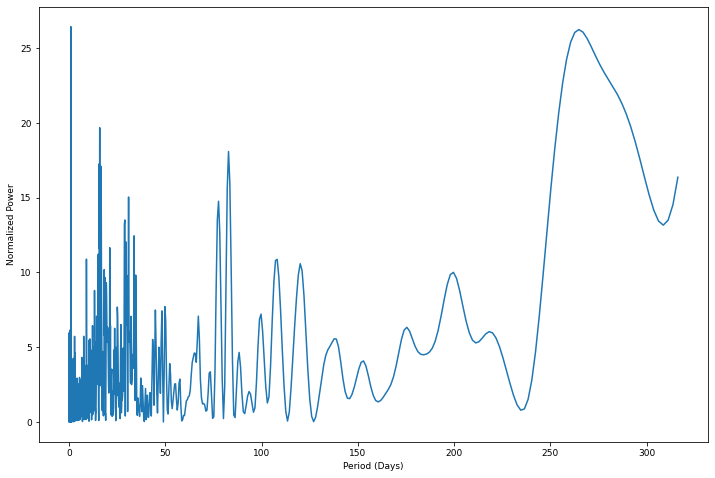

In [167]:
pgram_window = signal.lombscargle(t, np.ones(len(t)), freqs) # window function: replace RVs with one
fig , ax = plt.subplots(1,figsize=(12,8))
ax.plot(pers,pgram_window)
ax.set_xlabel('Period (Days)')
ax.set_ylabel('Normalized Power')
ax.set_xlabel('')
plt.show()

Note: these signals are not real. They stem from unfortunate time sampling. While initially this does not appear to explain our strong signal at ~5.2 days, we also might be seeing beat frequency signals. Consider the strong signal $P_{obs}$ from the window function at ~1 day. 

$$ P_{new}^{-1} = P_{b}^{-1} - P_{obs}^{-1}$$

$$ P_{new}^{-1} = 0.837491^{-1} - 1 $$

$$ P_{new} = 5.15 \text{ days.} $$ This explains the previous signal at ~5.2 days

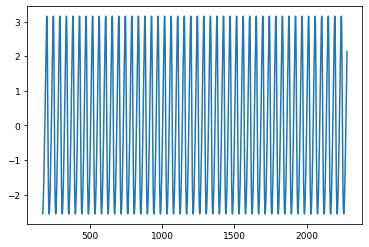

In [156]:
e_c = x[7]**2 + x[8]**2
om_c = np.arctan2(x[8],x[7])
orbel = [x[5], x[6], e_c, om_c, np.power(np.e,x[9])]
rv_c_new = rv_drive(t_new, orbel,use_c_kepler_solver=True) # use_c_kepler_solver Kepler's equation tells us that eccentric anomaly E is both outside/inside a sin function => 
# transcendental equation => cannot analytically solve => use_c_kepler_solver to solve it. 
rv_c = rv_drive(t, orbel,use_c_kepler_solver=True) 
plt.plot(t_new,rv_c_new)

(400.0, 450.0)

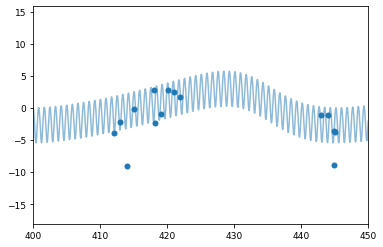

In [112]:
plt.scatter(t,rv)
plt.plot(t_new, rv_b+rv_c, alpha = 0.5)
plt.xlim((400,450))

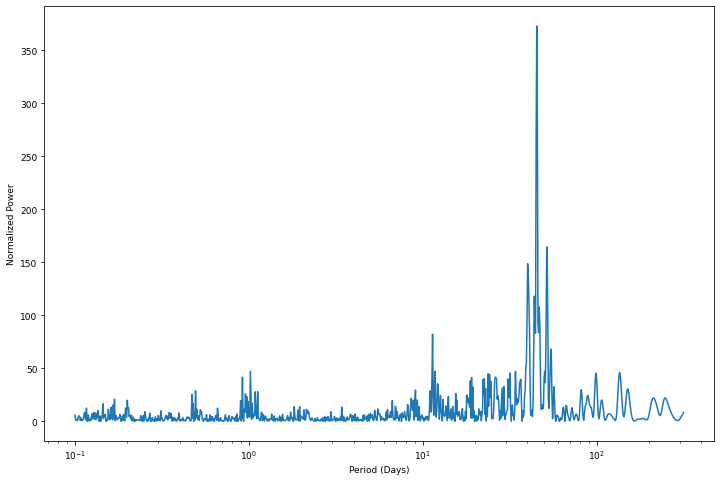

In [164]:
pgram_c = signal.lombscargle(t, rv_c, freqs) # lomb scargle periodogram used b/c normal scipy periodogram requires equally spaced time series
fig , ax = plt.subplots(1,figsize=(12,8))
ax.plot(pers,pgram_c)
ax.set_xlabel('Period (Days)')
ax.set_ylabel('Normalized Power')
ax.set_xscale('log')
plt.show()

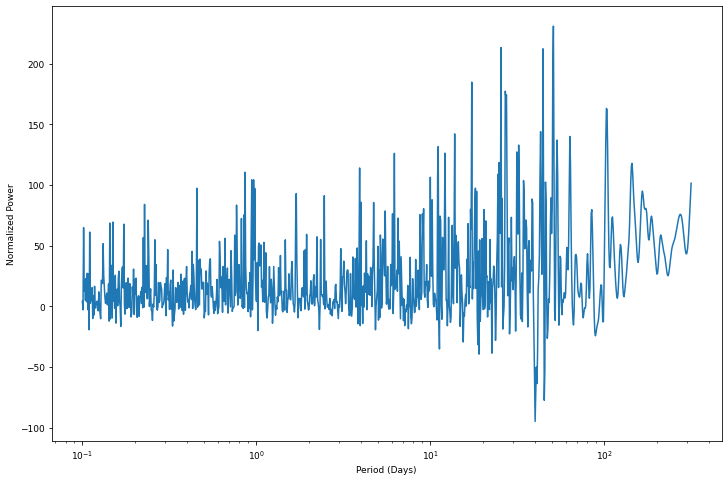

In [161]:
final_pgram = pgram - pgram_b - pgram_c
fig , ax = plt.subplots(1,figsize=(12,8))
ax.plot(pers,final_pgram)
ax.set_xlabel('Period (Days)')
ax.set_ylabel('Normalized Power')
ax.set_xscale('log')
plt.show()